<a href="https://colab.research.google.com/github/xxxnmxhj00/Mini-Project/blob/main/%5BTF%5DTransformers_%EA%B5%AC%ED%98%84_%EC%98%81%EC%96%B4_%ED%94%84%EB%9E%91%EC%8A%A4_%EB%B2%88%EC%97%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu==2.8.0rc0

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.__version__)
print(device_lib.list_local_devices())

2.8.0-rc0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12682301425268333747
xla_global_id: -1
]


In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


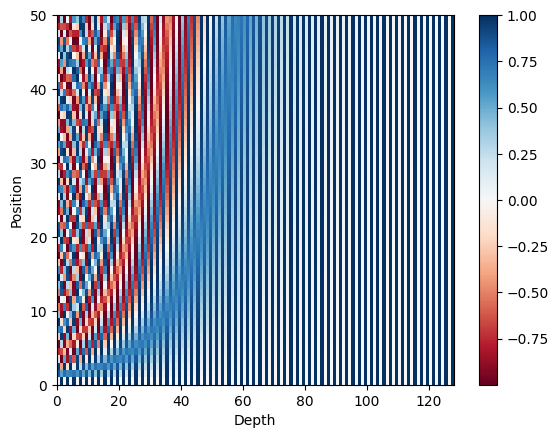

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [ ]:
# 임의의 Query, Key, Value인 Q, K, V 행렬 생성
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

In [ ]:
temp_output, temp_att = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_output) # 어텐션 값
print(temp_att)

tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)


In [ ]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
temp_q

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.,  0., 10.]], dtype=float32)>

In [ ]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [ ]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [ ]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)


In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  # 패딩 마스크(두번째 서브층)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


In [ ]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


In [ ]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


(1, 9000, 128)
(1, 9000, 128)


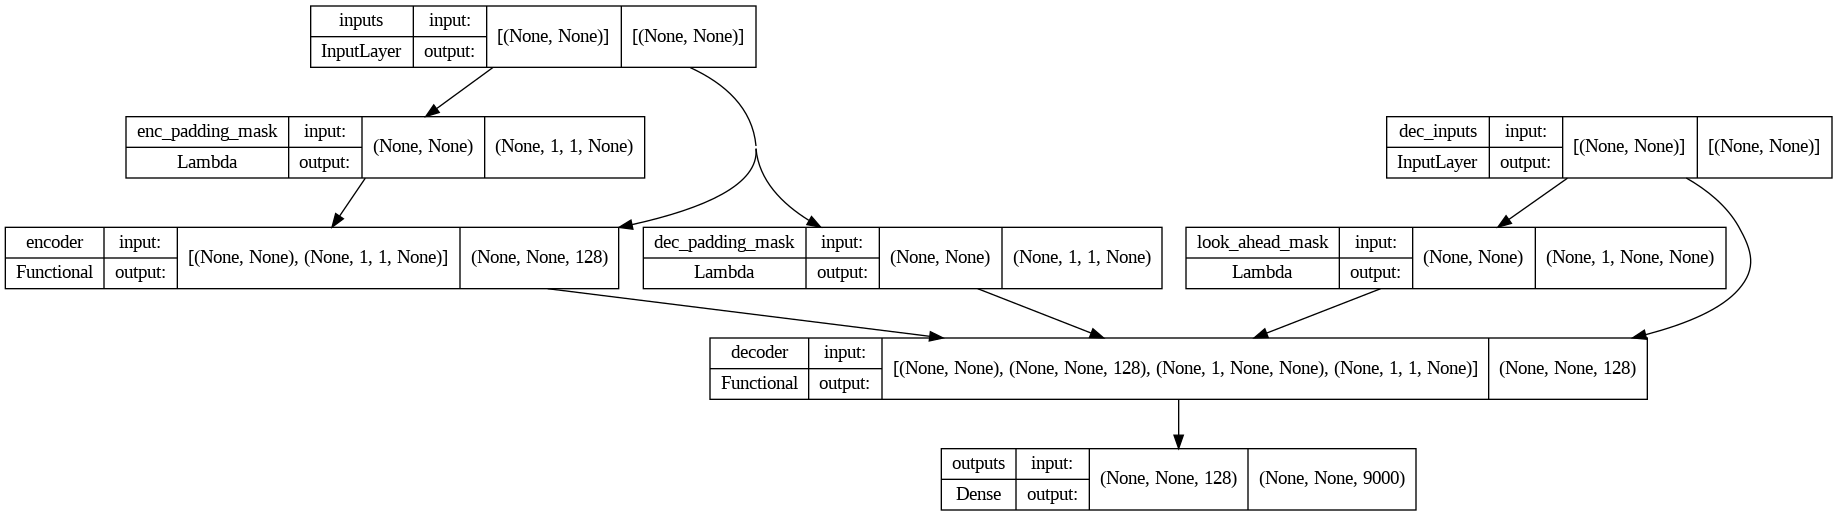

In [ ]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

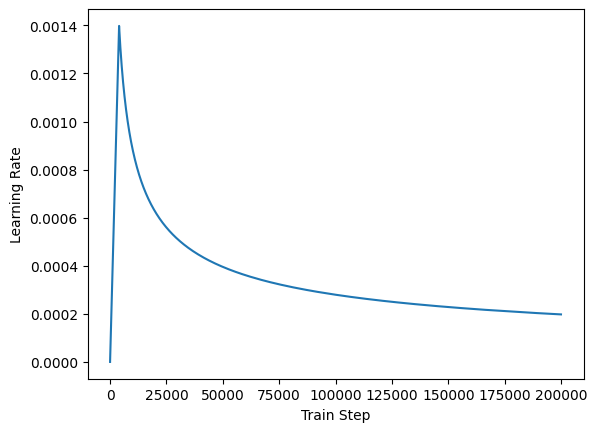

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")


번역 테스크 시작

In [ ]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import text

In [ ]:
!wget http://www.manythings.org/anki/fra-eng.zip


--2024-09-05 00:44:50--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7943074 (7.6M) [application/zip]
Saving to: ‘fra-eng.zip.1’

fra-eng.zip.1       100%[===================>]   7.57M  3.91MB/s    in 1.9s    

2024-09-05 00:44:52 (3.91 MB/s) - ‘fra-eng.zip.1’ saved [7943074/7943074]



In [ ]:
filename = 'fra-eng.zip'
path = os.getcwd()                                      # os.getcwd() 함수는 현재 작업 디렉토리의 경로를 반환
zipfilename = os.path.join(path, filename)              # os.path.join() 함수는 path와 filename을 결합하여 ZIP 파일의 전체 경로를 생성

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:      # zipfile.ZipFile() 클래스는 ZIP 파일을 읽거나 쓰기 위한 객체를 생성
    zip_ref.extractall(path)                            # extractall() 메서드는 ZIP 파일의 모든 파일을 지정된 디렉토리에 추출

In [ ]:
train_data = pd.read_table('fra.txt', usecols=[0,1], header = None)
train_data.head(3)

,0,1
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !


In [ ]:
train_data.columns = ['en', 'fr']
display(train_data.head(3))
display(train_data.info())

,en,fr
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232736 entries, 0 to 232735
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   en      232736 non-null  object
 1   fr      232736 non-null  object
dtypes: object(2)
memory usage: 3.6+ MB


None

In [ ]:
en_sentence = []
for sentence in train_data['en']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    en_sentence.append(sentence)

In [ ]:
fr_sentence = []
for sentence in train_data['fr']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    fr_sentence.append(sentence)

In [ ]:
fr_sentence[:10]

['Va  !',
 'Marche .',
 'En route  !',
 'Bouge  !',
 'Salut  !',
 'Salut .',
 'Cours\u202f !',
 'Courez\u202f !',
 'Prenez vos jambes à vos cous  !',
 'File  !']

In [ ]:
en_sentence[:10]

['Go .',
 'Go .',
 'Go .',
 'Go .',
 'Hi .',
 'Hi .',
 'Run !',
 'Run !',
 'Run !',
 'Run !']

In [ ]:
# 서브워드텍스트인코더를 사용하여 en, fr 데이터로 부터 집합(voca)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(en_sentence + fr_sentence,
                                                                      target_vocab_size=2**13)

In [ ]:
tokenizer.vocab_size

8128

In [ ]:
tokenizer.subwords[:100] # 워드가 뭐 있는지 확인할 수 있음, 언더바가 있음

[' .',
 'I_',
 'a_',
 'to_',
 'de_',
 'Je_',
 'Tom_',
 'you_',
 ' ?',
 'the_',
 't_',
 's_',
 'pas_',
 'que_',
 'est_',
 ' ,  ',
 'à_',
 'ne_',
 'vous_',
 'le_',
 '  ?',
 'la_',
 'is_',
 'ai_',
 'un_',
 'me_',
 'ce_',
 'tu_',
 'Il_',
 'of_',
 'that_',
 'en_',
 'in_',
 'une_',
 'you',
 'je_',
 'was_',
 'have_',
 'il_',
 'm_',
 're_',
 'don',
 'for_',
 'suis_',
 'do_',
 'pour_',
 'your_',
 'He_',
 'les_',
 'You_',
 'be_',
 'The_',
 'on_',
 'Nous_',
 'my_',
 '\xa0 ?',
 'y_',
 'e_',
 'want_',
 'Tu_',
 'this_',
 'not_',
 'know_',
 'd_',
 'it_',
 'qu',
 'Vous_',
 'like_',
 'are_',
 'it',
 'nous_',
 'dans_',
 'We_',
 'Tom',
 'as_',
 'des_',
 'te_',
 'with_',
 'faire_',
 '\u202f ?',
 've_',
 'me',
 'plus_',
 'll_',
 'that',
 'think_',
 'se_',
 'Elle_',
 'at_',
 'était_',
 '  !',
 'She_',
 'You',
 'what_',
 'du_',
 'être_',
 'Do_',
 'é_',
 'au_',
 'avec_']

In [ ]:
# 시작토큰과 종료 토큰에 정수 인덱스를 표기

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size+1]

In [ ]:
# 시작토큰과 종료 토큰을 고려하여 단어 집합의 크기를 +2, 시작 토큰과 종료 토큰을 추가하기 위해 사용
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print('시작 토큰의 번호 :',START_TOKEN)
print('종료 토큰의 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰의 번호 : [8128]
종료 토큰의 번호 : [8129]
단어 집합의 크기 : 8130


In [ ]:
tokenizer.encode('This is a book') # 텍스트를 토큰화하고 해당 토큰들을 정수 시퀀스로 변환하는 메서드

[113, 23, 3, 682]

In [ ]:
tokenizer.encode("C'est un livre.")

[7939, 7911, 15, 25, 760, 7918]

In [ ]:
tokenizer.decode([7939, 7911, 15, 25, 760, 7918])

"C'est un livre."

In [ ]:
tokenizer.decode([113, 23, 3, 682])

'This is a book'

In [ ]:
# 최대 길이를 20으로 정의, 패딩을 해주는 것
MAX_LENGTH = 20

In [ ]:
# 토큰화/ 정수 인코딩/ 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(input, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(input, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가, 인코딩 숫자로 바꾸는 것 토크나이즈하고 정수로 인코딩
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # max_length의 길이만큼 패딩
    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 불필요한 반복 제거
  # tokenized_inputs.append(sentence1)
  # tokenized_outputs.append(sentence2)

  # 다음 줄들이 함수의 일부로 포함되도록 들여쓰기 수정
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs # 변수 반환

In [ ]:
en_sentence,fr_sentence = tokenize_and_filter(en_sentence, fr_sentence)

In [ ]:
en_sentence.shape # 패딩이 잘되어 특성이 20이 됨

(232736, 20)

In [ ]:
fr_sentence.shape

(232736, 20)

In [ ]:
en_sentence[0]

array([8128, 7869,    1, 8129,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
fr_sentence[0]

array([8128, 6120,   91, 8129,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
# 텐서플로우와 dataset을 이용하여 셔플을 수행하되, 배치 크기로 데이터를 묶는다
# 또한 이 과정에서 교사 강요를 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': en_sentence,
        'dec_inputs': fr_sentence[:, :-1]  # 디코더 입력 (마지막 토큰 제외)
    },
    {
        'outputs': fr_sentence[:, 1:]  # 실제값 (첫 번째 토큰 제외)
    }
))

# 캐싱, 셔플링, 배칭, 프리페칭 수행
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
model = transformer(
    vocab_size=VOCAB_SIZE, # 사전 크기 디코더 출력의 크기가 된다.
    num_layers=2, # 인코더 디코더 블록의 반복 횟수 논문에서는 6을 사용
    dff=512,  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기 논문에서는 2048
    d_model=128, # 피드 포워드 신경망 출력의 크기
    num_heads= 8, # 어텐션 헤드의 수 논문에서는 8
    dropout=0.1) # 드롭아웃 비율

(1, 8130, 128)
(1, 8130, 128)


In [ ]:
learning_rate = CustomSchedule(128)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
def accuracy(y_true, y_pred): # 예측값(y_pred)과 실제값(y_true) 간의 정확도를 계산하는 함수
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1)) # y_true의 모양을 변경하여, 배치 크기와 시퀀스 길이에 맞게 만듭니다. 여기서 -1은 배치 크기를 자동으로 맞춰줌
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [ ]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
model.fit(dataset, epochs = 1)

3637/3637 [==============================] - 1949s 534ms/step - loss: 1.7709 - accuracy: 0.2882


In [ ]:
def preprocess_sentence(sentence):
  # 단어와 구두점 사이에 공백 추가.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
def evaluate(sentence): # 평가함수
  # 입력된 문장의 전처리 학습데이터와 동일하게 진행되어야 한다
  sentence = preprocess_sentence(sentence)

  # 입력받은 문장에 시작토큰과 종료토큰을 추가
  sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 시점의 예측 단어가 종료 토큰이면 예측 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 현재 시점의 예측 단어를 출력에 연결
    output = tf.concat([output, predicted_id], axis=-1)
# 단어 예측이 모두 끝났다면 예측한 단어를 출력
  return tf.squeeze(output, axis=0)

In [ ]:
# 사용자 정의 함수 evulate()을 호출한 반환결과는 숫자값으로 인코딩된 형태이기 때문에
# 이를 다시 토큰라이저기반으로 만든 사전을 이용하여 디코딩 해야 자연어로 변환된다
def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('예측 : {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
predict('I love you')

입력 : I love you
예측 : J'aime que tu t'aimes .


"J'aime que tu t'aimes ."

In [ ]:
import random

for i in range(10):
  idx = random.randint(0, len(en_sentence))
  pred = predict(train_data['en'].iloc[idx])
  print('정답 : {}'.format(train_data['fr'].iloc[idx]))
  print('-' * 30)

입력 : The house is made of stone.
예측 : La maison est fait de pierre .
정답 : La maison est en pierre.
------------------------------
입력 : She speaks a little Arabic.
예측 : Elle parle un peu de chansons .
정답 : Elle parle un peu l'arabe.
------------------------------
입력 : Tom didn't know Mary was so funny.
예측 : Tom ne savait pas que Mary était si drôle .
정답 : Tom ne savait pas que Mary était si marrante.
------------------------------
입력 : My name's Tom.
예측 : Mon nom de Tom est nom .
정답 : Mon nom est Tom.
------------------------------
입력 : Tom is a thief and a liar.
예측 : Tom est un voleur et un cancer .
정답 : Tom est un voleur et un menteur.
------------------------------
입력 : How many of your students are here?
예측 : Combien de vos élèves sont ici  ?
정답 : Combien de vos élèves se trouvent ici ?
------------------------------
입력 : He asked his teacher stupid questions.
예측 : Il demanda de son professeur stupide .
정답 : Il posa des questions stupides à son professeur.
--------------------------